# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Загружаем основные модули

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
import numpy as np

from sklearn.metrics import mean_squared_error # для расчета MSE и RMSE
from sklearn.linear_model import LinearRegression # линейная регрессия
from scipy import stats as st # для доверительного интервала

Загружаем дополнительные модули

In [2]:
import seaborn as sns 
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Загружаем данные

In [3]:
geo = []
for i in range(3):
    try:
        geo.append(pd.read_csv('geo_data_'+ str(i) +'.csv', sep=','))
    except:
        geo.append(pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_'+ str(i) + '.csv', sep=','))

Смотрим инфо данных

In [4]:
for i in range(3):
    display(geo[i].info(), geo[i].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Типы данных менять не нужно.
Мы видим столбец id, который не несёт полезных для машинного обучения данных, удаляем.

In [5]:
for df in range(len(geo)):
    geo[df] = geo[df].drop('id', axis = 1)

Проверяем на одном из датасетов (т.к. со всеми провели аналогичную операцию)

In [6]:
geo[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


Проверяем данные на пропуски

In [7]:
for i in range(3):
    print('Количество пропусков в датасете geo', i, ':\n', geo[i].isna().sum() )

Количество пропусков в датасете geo 0 :
 f0         0
f1         0
f2         0
product    0
dtype: int64
Количество пропусков в датасете geo 1 :
 f0         0
f1         0
f2         0
product    0
dtype: int64
Количество пропусков в датасете geo 2 :
 f0         0
f1         0
f2         0
product    0
dtype: int64


### Исследование данных
Смотрим на корелляцию данных

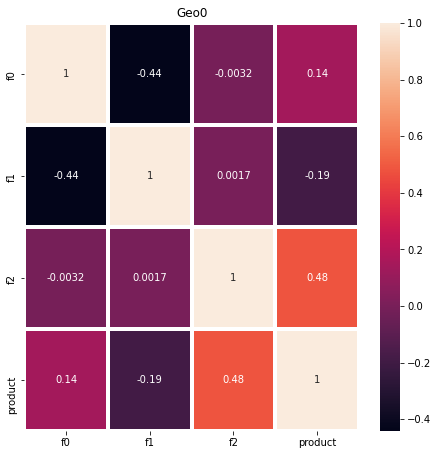

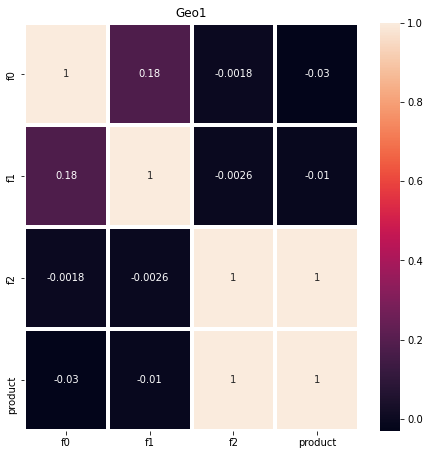

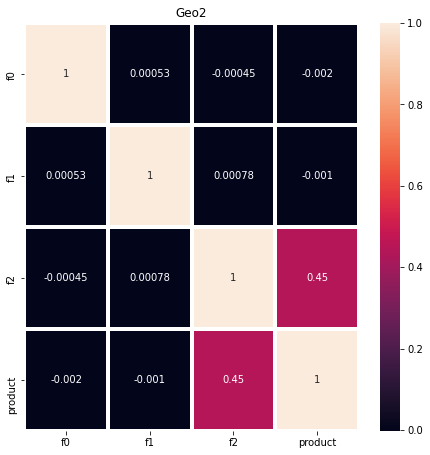

In [8]:
for i in range(3):
    plt.rcParams['figure.figsize'] = (7.5, 7.5)
    sns.heatmap(geo[i].corr(), annot=True, linewidths=3, linecolor='white').set_title('Geo' + str(i))
    plt.show()

Корелляция между признаками низкая. Однако, признак f2 имеет наибольшую корелляцию с product, из чего можно сделать вывод, что это самый значимый признак. Более того, во geo1 корелляция между f2 и product единица. Тем не менее, учитывая, что корелляции между признаками нет, убирать какие-либо данные не нужно.

### Разбиение данных на обучающую и валидационную выборки

Для начала разобьём данные на признаки и целевой признак

In [9]:
target = []
features = []
for i in range(3):
    target.append(geo[i]['product'])
    features.append(geo[i].drop('product', axis = 1))

Теперь разобьём выборки на обучающие и валидационные

In [10]:
    features_train = []
    features_valid = []
    target_train = []
    target_valid = []
    
    for i in range(3):
        f_train, f_valid, t_train, t_valid = train_test_split(features[i], target[i], 
                                                                                  test_size=0.25, random_state=42)
        features_train.append(f_train)
        features_valid.append(f_valid)
        target_train.append(t_train)
        target_valid.append(t_valid)

In [11]:
features_train[0].info(), target_train[0].to_frame().info(), features_valid[0].info(), target_valid[0].to_frame().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75000 entries, 98980 to 15795
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f0      75000 non-null  float64
 1   f1      75000 non-null  float64
 2   f2      75000 non-null  float64
dtypes: float64(3)
memory usage: 2.3 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 75000 entries, 98980 to 15795
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   product  75000 non-null  float64
dtypes: float64(1)
memory usage: 1.1 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 75721 to 11627
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f0      25000 non-null  float64
 1   f1      25000 non-null  float64
 2   f2      25000 non-null  float64
dtypes: float64(3)
memory usage: 781.2 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 en

(None, None, None, None)

Проверили разбиение на первом датасете, всё прошло успешно. Остальные разбивались по аналогичному принципу.

## Обучение и проверка модели

### Обучение модели

Нормализуем данные

In [12]:
for i in range(3):
    scaler = StandardScaler()
    scaler.fit(features_train[i])
    features_train[i] = scaler.transform(features_train[i])
    features_valid[i] = scaler.transform(features_valid[i])

features_train[0]

array([[ 1.27478613, -0.79973892, -0.39667731],
       [-1.60068908,  0.23467771, -2.16928343],
       [-0.32379132,  1.43629697,  1.49542545],
       ...,
       [ 0.54922933, -1.59163214,  0.11909049],
       [ 0.17517618, -1.45934448,  1.42952353],
       [ 1.02980347, -1.42062472, -0.1494586 ]])

Пишем функцию для рассчёта RMSE

In [13]:
def RMSE(y,x):
    return mean_squared_error(y, x)**0.5

Обучаем модели, сохраняя предсказанные данные в отдельную переменную

In [14]:
predictions = []
rmse = []
predictions_mean = []

for i in range(3):
    model = LinearRegression()
    model.fit(features_train[i], target_train[i])
    
    pred = model.predict(features_valid[i])
    predictions.append(pred)
    rmse.append(RMSE(target_valid[i], pred))
    predictions_mean.append(pred.mean() )
    print(i, RMSE(target_valid[i], pred))
    
print('-----------------------------------------------------------')

for i in range(3):
    for i2 in [0, 1, 2]:
        f_t = np.delete(features_train[i],  i2, axis = 1)
        f_v = np.delete(features_valid[i],  i2, axis = 1)
        model = LinearRegression()
        model.fit(f_t, target_train[i])
        pred = model.predict(f_v)
        print('Датасет:', i, ' Из него убираем:', i2, 'RMSE',  RMSE(target_valid[i], pred))
        

0 37.75660035026169
1 0.8902801001028846
2 40.145872311342174
-----------------------------------------------------------
Датасет: 0  Из него убираем: 0 RMSE 37.861273208916586
Датасет: 0  Из него убираем: 1 RMSE 38.254383933851834
Датасет: 0  Из него убираем: 2 RMSE 43.450295287774786
Датасет: 1  Из него убираем: 0 RMSE 1.557959948925455
Датасет: 1  Из него убираем: 1 RMSE 0.8967835153571673
Датасет: 1  Из него убираем: 2 RMSE 45.92399973816207
Датасет: 2  Из него убираем: 0 RMSE 40.14518184292225
Датасет: 2  Из него убираем: 1 RMSE 40.14597151400041
Датасет: 2  Из него убираем: 2 RMSE 44.783190417248896


### Анализ результатов работы моделей

In [15]:
for i in range(3):
    print('Для региона '+str(i)+' средний запас предсказанного сырья составил {:.2f}, а RMSE модели {:.2f}'.
          format(predictions_mean[i], rmse[i]))


Для региона 0 средний запас предсказанного сырья составил 92.40, а RMSE модели 37.76
Для региона 1 средний запас предсказанного сырья составил 68.71, а RMSE модели 0.89
Для региона 2 средний запас предсказанного сырья составил 94.77, а RMSE модели 40.15


Сравниваем с истинными значениями

In [16]:
for i in range(3):
    print('Для региона '+str(i)+' истинный средний запас сырья равен {:.2f}. Отклонение предсказаний, сделанных моделями: {:.2g}'
          .format(target_valid[i].mean(),abs(predictions_mean[i] - target_valid[i].mean()) ))

Для региона 0 истинный средний запас сырья равен 92.33. Отклонение предсказаний, сделанных моделями: 0.073
Для региона 1 истинный средний запас сырья равен 68.73. Отклонение предсказаний, сделанных моделями: 0.013
Для региона 2 истинный средний запас сырья равен 95.15. Отклонение предсказаний, сделанных моделями: 0.38


### Вывод

Модели очень точно предсказывают средний запас сырья, отклонения всего на несколько сотых. Лучше всего справляется модель для региона 1, т.к. там сильная корелляция между параметром и целевым признаком. При том, истинное и предсказанное количество сырья в регионе 1 меньше чем в остальных двух. Можно заметить взаимосвязь - чем больше сырья в регионе, тем хуже справляется модель (наибольшее RMSE в регионе 2, где макимальный запас сырья, в регионе 0 чуть меньше отклонение и чуть меньше запас)

## Подготовка к расчёту прибыли

### Ввводим необходимые переменные

In [17]:
explore_count = 500 # количество точек для исследования
mining_count = 200 # количество точек для разработки
mining_budget = 10000 # бюджет на разработку скважин в регионе в миллионах рублей
revenue_per_barrel = 0.45 # доход с 1000 баррель в миллионах рублей рублей
loss_probability = 0.025 # максимальная допустмая вероятность убытков
bootstrap_samples = 1000

### Рассчёт необходимого количества сырья для безубыточной разработки скважины

Считаем затраты на одну скважину

In [18]:
budget_per_borehole = mining_budget / mining_count
budget_per_borehole

50.0

Необходимое количество сырья для безубыточной добычи сырья

In [19]:
sufficient_product_volume = budget_per_borehole / revenue_per_barrel
sufficient_product_volume

111.11111111111111

Сравниваем необходимое количество сырья со среднем в каждом регионе

In [20]:
for i in range(3):
    print('Запас сырья в регионе ' + str(i) + ' отличается на ' 
          + str(target_valid[i].mean() - sufficient_product_volume ) ) 

Запас сырья в регионе 0 отличается на -18.785154740267245
Запас сырья в регионе 1 отличается на -42.38573036388367
Запас сырья в регионе 2 отличается на -15.960112039391504


### Вывод
Средний запас сырья в каждом регионе меньше необходимого. Таким образом, при выборе случайных скважин велик риск получить убытки. Чтобы избежать этого - нужно пользуясь моделью выбрать наиболее перспективные скважины. Ниже проверим работоспособность моделей.

## Расчёт прибыли и рисков 

Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
 4.1. Выберите скважины с максимальными значениями предсказаний. 
 4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
 4.3. Рассчитайте прибыль для полученного объёма сырья.

### Рассчёт прибыли для 200 лучших скважин в кадом регионе

In [21]:
def profit(true_valid, pred_valid, count):
    top = pd.Series(pred_valid).sort_values(ascending=False).head(count)
    target_ = true_valid.reset_index(drop=True)[top.index]
    return target_.sum() * revenue_per_barrel

Считаем прибыль для каждого региона

In [22]:
print('Прибыль в с 200 выбранных по предсказаниям модели скважин составит:')
for i in range(3):
    regprofit = profit(target_valid[i], predictions[i], 200)

    print('для региона'+str(i)+' - {:.3f} млн. руб.'.
          format(regprofit - mining_budget))

Прибыль в с 200 выбранных по предсказаниям модели скважин составит:
для региона0 - 3359.141 млн. руб.
для региона1 - 2415.087 млн. руб.
для региона2 - 2598.572 млн. руб.


#### Промежуточный вывод
Мы получили очень хорошие показатели прибыли, однако такое возможно только в случае, если мы проведём разведку всех скважен в каждом регионе, а по условиям заказчика мы можем разведать только 500 скважин. Рассчитаем прибыль и риски в заданных условиях.

### Расчет рисков и прибыли для каждого региона (для 500 случайных скважин)

Используем технику Bootstrap для 1000 выборок. Будем считать выручку внутри каждой выборки, оценивая не убыточна ли она. В итоге определим среднюю вырочку для региона, доверительный интервал и вероятность убочтосности.

In [23]:
def income_region(p_val, t_val, boots, counts):
    state = np.random.RandomState(42)
    counter = 0 #Для рассчёта вероятности убытка
    profits = [] #Значения выручек
    for i in range(boots):
        # Случайно выбираем скважины в валидационной выборке
        target_subsample = t_val.reset_index(drop=True).sample(counts, replace=True, random_state=state)
        # из предсказаний выбираем строки соответствующие нашей подвыборке
        probs_subsample = p_val[target_subsample.index]
        # считаем выручку для отобранных строк
        p = profit(target_subsample, probs_subsample, mining_count) - mining_budget
        profits.append(p)
        
        if p < 0:
            counter += 1
        
    #Средняя выручка
    profits = pd.Series(profits)
    mean_profit = profits.mean()
    print('Средняя выручка для региона равна {:.5} миллионов рублей'.format(mean_profit))
    #Доверительный интервал
    confidence_interval = st.t.interval(0.95, len(profits)-1, profits.mean(), np.std(profits, ddof=1))
    print("95%-ый доверительный интервал:", confidence_interval)
    
    loss = 1 * counter / bootstrap_samples
    if loss <loss_probability:
        print('Вероятность убытков равна {:.2%} и является меньше допустимой. Данный регион соответствует критериям'.
              format(loss))
    else:
        print('Вероятность убытков равна {:.2%} и является больше допустимой. Данный регион не соответствует критериям'.
              format(loss))  

Применем функцию к нашим регионам

In [24]:
for i in range(3):
    print('Регион '+ str(i))
    income_region(predictions[i], target_valid[i], 1000, 500)
    print()

Регион 0
Средняя выручка для региона равна 399.58 миллионов рублей
95%-ый доверительный интервал: (-109.85269895835654, 909.0036550668165)
Вероятность убытков равна 6.00% и является больше допустимой. Данный регион не соответствует критериям

Регион 1
Средняя выручка для региона равна 452.05 миллионов рублей
95%-ый доверительный интервал: (50.06111244366468, 854.0366693692526)
Вероятность убытков равна 1.50% и является меньше допустимой. Данный регион соответствует критериям

Регион 2
Средняя выручка для региона равна 375.01 миллионов рублей
95%-ый доверительный интервал: (-139.6578408911314, 889.6776467217901)
Вероятность убытков равна 8.00% и является больше допустимой. Данный регион не соответствует критериям



In [25]:
model.intercept_

94.9496669760935

## Вывод
На первый взгляд лучше всего подходит первый регион - регион 0. Выручка по 200 лучшим точкам составляет для него 3359.141 млн. руб., а для региона 1 -2415.087 млн. руб. Тем не менее, проверка методом Bootstrap показала, что при разведке 500 случайных скважин средняя выручка выше у региона 1, кроме того, вероятность убытков для него составляет всего 1.5%.

<b>Лучший регион - второй регион (регион1)</b>